In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import toeplitz
from scipy.special import sici
import time
import numba as nb

In [2]:
def get_acf(tau,f1,f2):
    s1,c1=sici(2*np.pi*f1*tau)
    s2,c2=sici(2*np.pi*f2*tau)
    y=2*(c2-c1)
    y=np.nan_to_num(y,nan=2*np.log(f2/f1)+1e-3)
    return y

In [3]:
f1=0.05
f2=0.5
N=2*1000
ps=np.zeros(N//2+1,dtype='complex128')
ps[int(f1*N):int(f2*N)+1]=1/np.arange(int(f1*N),int(f2*N)+1) #N/2 is the scaling factor to line the two PS up.
acf_dft=N*np.fft.irfft(ps)
acf_anl=get_acf(np.arange(0,N//2+1),f1,f2)

/tmp/ipykernel_243964/2585838835.py:4: RuntimeWarning: invalid value encountered in subtract
  y=2*(c2-c1)


In [160]:
np.sum(ps)

(1.6097379324341+0j)

In [161]:
acf_dft[0]

3.2193758648682

In [316]:
f1=0.05;f2=0.5
a1=get_acf(np.arange(0,10000),f1,f2)
f1=0.005;f2=0.05
a2=get_acf(np.arange(0,10000),f1,f2)

/tmp/ipykernel_1267338/2585838835.py:4: RuntimeWarning: invalid value encountered in subtract
  y=2*(c2-c1)


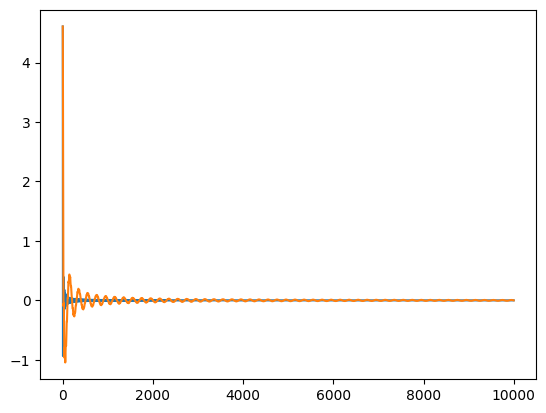

In [317]:
plt.plot(a1)
plt.plot(a2)

In [314]:
a2

array([4.60617019e+00, 4.55651812e+00, 4.41297033e+00, ...,
       2.24987557e-03, 2.02651326e-03, 1.99408120e-03])

(0.0, 100.0)

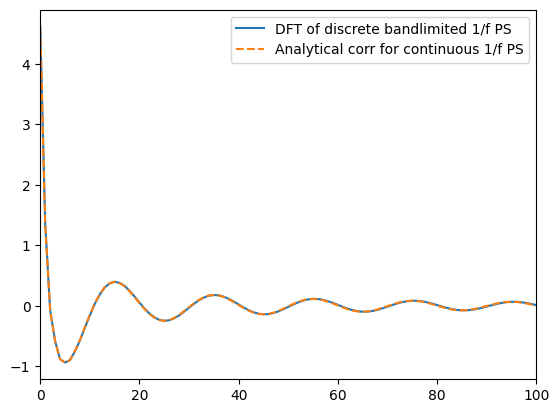

In [4]:
plt.plot(acf_dft, label='DFT of discrete bandlimited 1/f PS')
plt.plot(acf_anl,ls='--', label='Analytical corr for continuous 1/f PS')
plt.legend()
plt.xlim(0,100)

In [33]:
nlevels=3
nsamps=1000
bank=[]
for ll in range(nlevels+1):
    noise = N*np.fft.irfft(np.sqrt(ps/2) * (np.random.randn(N//2+1) + 1j * np.random.randn(N//2+1)))
    bank.append(noise[:nsamps].copy())

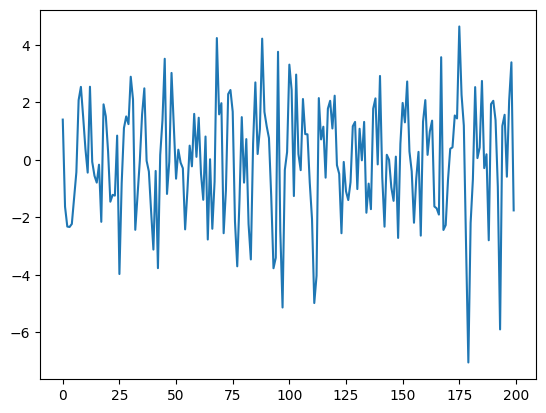

In [36]:
plt.plot(bank[0][0:200])

In [109]:
osampled=np.zeros(1000)
osampled2=osampled.copy()
yy=bank[0].copy()

In [130]:
center=100
bw=50
curpt=center
taus=np.linspace(bw,-bw,2*bw+1)
coeff=np.ones(len(taus))

In [133]:
taus

array([ 50.,  49.,  48.,  47.,  46.,  45.,  44.,  43.,  42.,  41.,  40.,
        39.,  38.,  37.,  36.,  35.,  34.,  33.,  32.,  31.,  30.,  29.,
        28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,  20.,  19.,  18.,
        17.,  16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,   7.,
         6.,   5.,   4.,   3.,   2.,   1.,   0.,  -1.,  -2.,  -3.,  -4.,
        -5.,  -6.,  -7.,  -8.,  -9., -10., -11., -12., -13., -14., -15.,
       -16., -17., -18., -19., -20., -21., -22., -23., -24., -25., -26.,
       -27., -28., -29., -30., -31., -32., -33., -34., -35., -36., -37.,
       -38., -39., -40., -41., -42., -43., -44., -45., -46., -47., -48.,
       -49., -50.])

In [142]:
tot=0
for j in range(1):
    for i in range(len(osampled)):   
        s=center + i/10
        pt = np.floor(s)
#         print(s,pt,s-pt,pt-50,pt+50)
#         osampled[i] = np.sum(np.sinc(taus+s-pt)*yy[int(pt)-bw:int(pt)+bw+1])
        t1=time.time()
        osampled[i] = coeff@yy[int(pt)-bw:int(pt)+bw+1]
        t2=time.time()
        tot+=t2-t1
print(tot/1000)

3.7608146667480467e-06


In [122]:
time

<module 'time' (built-in)>

In [127]:
yft=np.fft.rfft(yy[100:200])
osampft = np.zeros(1000//2+1,dtype='complex64')
print(yft.shape)
tot=0
for i in range(1000):
    t1=time.time()
    osampft[:51]=yft
    osampft[51:]=0.+0j
    osampled2=np.fft.irfft(osampft)
    t2=time.time()
    tot+=t2-t1
print(tot/1000)

(51,)
1.7215967178344727e-05


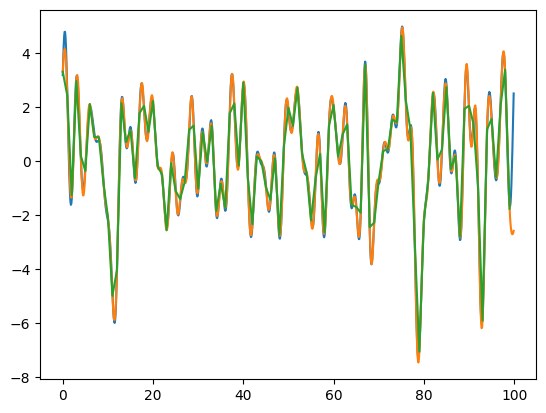

In [139]:
plt.plot(np.arange(0,1000)*0.1,10*osampled2)
plt.plot(np.arange(0,1000)*0.1,osampled)
plt.plot(yy[100:200])

In [107]:
level2=osampled+bank[2]

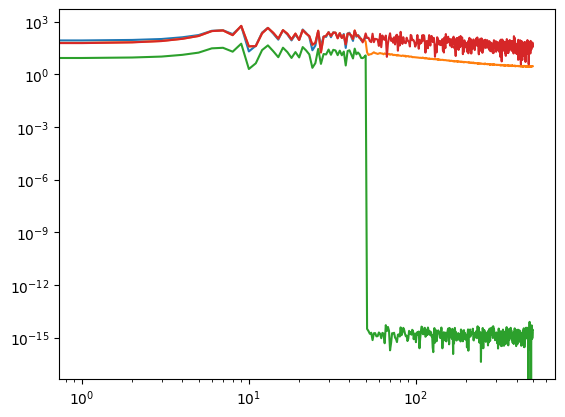

In [125]:
plt.loglog(10*np.abs(np.fft.rfft(yy[100:200])))
plt.loglog(np.abs(np.fft.rfft(osampled)))
plt.loglog(np.abs(np.fft.rfft(osampled2)))
plt.loglog(np.abs(np.fft.rfft(level2)))
#orange is not an ideal low-pass because of truncated sinc.

In [4]:
nsamps=1000
acf_anl=get_acf(np.arange(0,nsamps),f1,f2)
C=toeplitz(acf_anl)
Cinv=np.linalg.inv(C)
vec=get_acf(np.arange(0,nsamps)+1,f1,f2)
vec=vec[::-1]
coeffs=vec.T@Cinv
sigma = np.sqrt(C[0,0]-vec@Cinv@vec.T)
print(sigma)

1.3552707777948665


/tmp/ipykernel_243964/2585838835.py:4: RuntimeWarning: invalid value encountered in subtract
  y=2*(c2-c1)


In [6]:
tau=my_tau+0.1
vec=get_acf(tau,f1,f2)
vec=vec[::-1]
coeff=Cinv@vec

In [8]:
my_tau

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

(900.0, 1000.0)

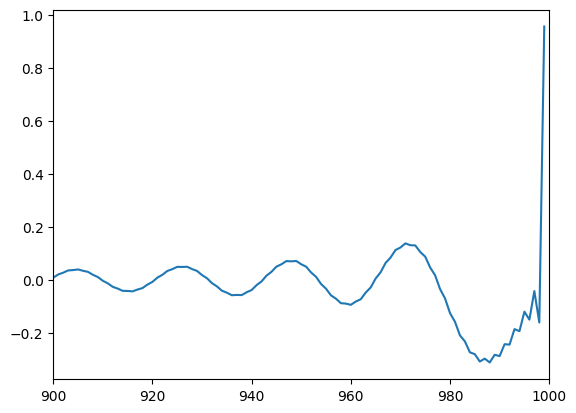

In [9]:
plt.plot(coeff)
plt.xlim(900,1000)

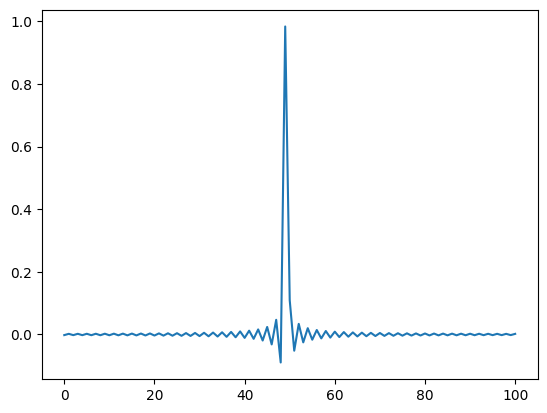

In [31]:
plt.plot(np.sinc(np.linspace(-50,50,101)+0.9))
# plt.xlim(0,100)

In [32]:
np.linspace(-50,50,101)+0.9

array([-49.1, -48.1, -47.1, -46.1, -45.1, -44.1, -43.1, -42.1, -41.1,
       -40.1, -39.1, -38.1, -37.1, -36.1, -35.1, -34.1, -33.1, -32.1,
       -31.1, -30.1, -29.1, -28.1, -27.1, -26.1, -25.1, -24.1, -23.1,
       -22.1, -21.1, -20.1, -19.1, -18.1, -17.1, -16.1, -15.1, -14.1,
       -13.1, -12.1, -11.1, -10.1,  -9.1,  -8.1,  -7.1,  -6.1,  -5.1,
        -4.1,  -3.1,  -2.1,  -1.1,  -0.1,   0.9,   1.9,   2.9,   3.9,
         4.9,   5.9,   6.9,   7.9,   8.9,   9.9,  10.9,  11.9,  12.9,
        13.9,  14.9,  15.9,  16.9,  17.9,  18.9,  19.9,  20.9,  21.9,
        22.9,  23.9,  24.9,  25.9,  26.9,  27.9,  28.9,  29.9,  30.9,
        31.9,  32.9,  33.9,  34.9,  35.9,  36.9,  37.9,  38.9,  39.9,
        40.9,  41.9,  42.9,  43.9,  44.9,  45.9,  46.9,  47.9,  48.9,
        49.9,  50.9])

convolution $y(t) = \sum_n sinc(t-n)x(n)$

(0.0, 50.0)

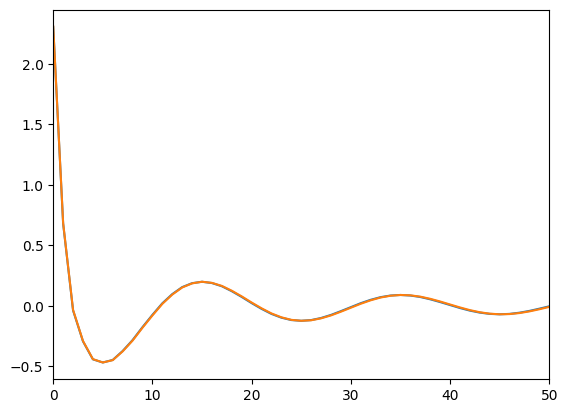

In [70]:
plt.plot(acf_anl)
plt.plot(acf_dft) #with moaare point dft will inch closer to analytical. with more point acf anl will decay down even more
plt.xlim(0,50)

In [5]:
npoints=1000
dtaus=np.arange(0,npoints+1)/npoints
coeff_arr = np.zeros((len(dtaus),nsamps))
my_tau = np.arange(0,nsamps)
dtaus[0]=1e-14

In [9]:
coeff_arr.shape

(1001, 1000)

In [10]:
for i,dtau in enumerate(dtaus):
    tau=my_tau+dtau
    vec=get_acf(tau,f1,f2)
    vec=vec[::-1]
    coeff=Cinv@vec
    coeff_arr[i,:]=coeff

In [11]:
u,s,vT=np.linalg.svd(coeff_arr)


In [12]:
maxs=8
svT = np.diag(s[:maxs])@vT[:maxs,:]
vsT=svT.T.copy()

In [13]:
#first 5 significant singvals
polyord=8
legcoeffs=np.zeros((maxs,polyord+1),dtype='float64') # singvals x order of poly+1
for i in range(maxs):
    colnum=i
    legcoeffs[i,:]=np.linalg.pinv(np.polynomial.legendre.legvander(np.linspace(-1,1,1001),polyord))@u[:,colnum]

In [129]:
uu=np.zeros(maxs,dtype='float64')
for i in range(maxs):
    uu[i]=np.polynomial.legendre.legval(2*1e-9 - 1,legcoeffs[i,:])
pred_coeff = uu@svT
tau=my_tau+1e-9
vec=get_acf(tau,f1,f2)
vec=vec[::-1]
actual_coeff=Cinv@vec

In [202]:
vsT@legcoeffs@np.polynomial.legendre.legvander(2*1e-9 - 1,polyord)[0] - pred_coeff

array([ 1.95241094e-19, -4.19704825e-19, -6.29345480e-19, -7.33530532e-19,
       -1.69406589e-20, -1.19601052e-18, -3.98444298e-18, -2.25480171e-18,
        2.55126324e-18, -4.18095463e-18, -5.99699327e-18, -5.60735811e-18,
        1.35186458e-18, -3.88957529e-18, -3.13741004e-18, -4.61632956e-18,
       -3.07049443e-18, -2.94174543e-18,  3.21025487e-19,  1.91429446e-19,
       -3.67612299e-19, -6.50521303e-19,  2.25988390e-18,  8.18911453e-18,
        1.93801138e-18,  9.65956373e-18,  1.53821183e-18, -4.74338450e-19,
       -3.15604476e-18, -2.94767466e-18,  3.98656057e-18, -1.30443074e-19,
        4.43845264e-19, -1.63985579e-18,  1.49416612e-18, -7.47760686e-18,
       -7.05409038e-18,  6.34935897e-18,  1.51110678e-18, -6.75254666e-18,
        8.23146618e-18, -6.98802181e-19, -1.94499941e-18,  1.25360876e-19,
        4.04881749e-19, -5.75982404e-20,  4.36052561e-18,  4.85519285e-18,
        9.45288769e-19,  1.07403778e-18,  6.19350491e-18, -3.27632344e-18,
        1.42301535e-19,  

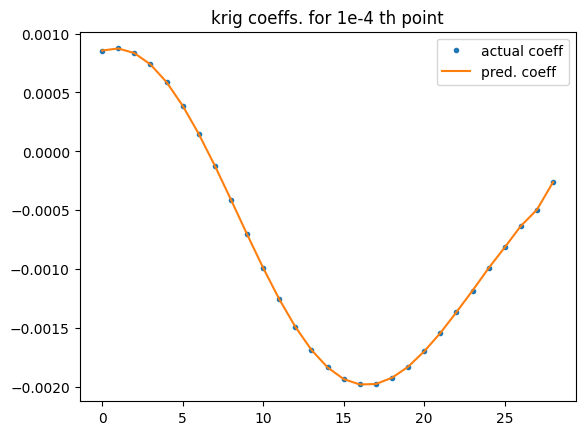

In [123]:
plt.title("krig coeffs. for 1e-4 th point")
plt.plot(actual_coeff[-30:-1],'.',label='actual coeff')
plt.plot(pred_coeff[-30:-1],label='pred. coeff')
plt.legend()

In [ ]:
#observation: small scale governed by higher less relevant sing vals. and require higher order polynomials to describe

In [128]:
np.polynomial.legendre.legvander(1.5,3)[0]

array([1.    , 1.5   , 2.875 , 6.1875])

In [14]:
@nb.njit()
def get_legendre(x,deg):
    #P0 = 1, P1 = x
    y = np.zeros(deg+1,dtype='float64')
    for i in range(deg+1):
        if i == 0: y[i]=1
        elif i==1: y[i]=x
        else:
            y[i] = (2*i-1)*x*y[i-1] - (i-1)*y[i-2]
            y[i]/=i
    return y
        

In [52]:
# @nb.njit()
def generate_data(legcoeffs,vsT,bank):
    nlevels=3
    nsamps=1000
    ndata=2000000
    mult=10 #10x every level
    fsamp=250e6
    spec = np.zeros(ndata)
    maxs=8
    polyord=8
    for i in range(0,nlevels+1):
        dt=mult**(i-nlevels)
        rand_bank = np.random.randn(int(ndata*dt)+1) #bank of random numbers for this level
        rand_ptr=0
        print("level", i, dt)
        for j in range(ndata):
            frac = (j*dt)%1
            pt = 1 if frac == 0 else frac
            # print("pt is", pt)
            coeffs=vsT@legcoeffs@get_legendre(pt,polyord)
            pred=coeffs@bank[i]
            #if integer multiple
            if frac==0.: #integers exactly rep. in floats
                #add noise
                krig_err=rand_bank[rand_ptr]*sigma
                bank[i]=np.roll(bank[i],-1)
                bank[i][-1]=krig_err
                pred+=krig_err
                rand_ptr+=1
            spec[j]+=(pred/np.sqrt(dt))
    return spec

In [53]:
for i in range(1):
    t1=time.time()
    spec=generate_data(legcoeffs,vsT,bank)
    t2=time.time()
    print(t2-t1)

level 0 0.001
level 1 0.01
level 2 0.1
level 3 1
91.18884778022766


In [54]:
np.var(spec)

240530.69000006732

Text(0, 0.5, 'PSD (arb. units)')

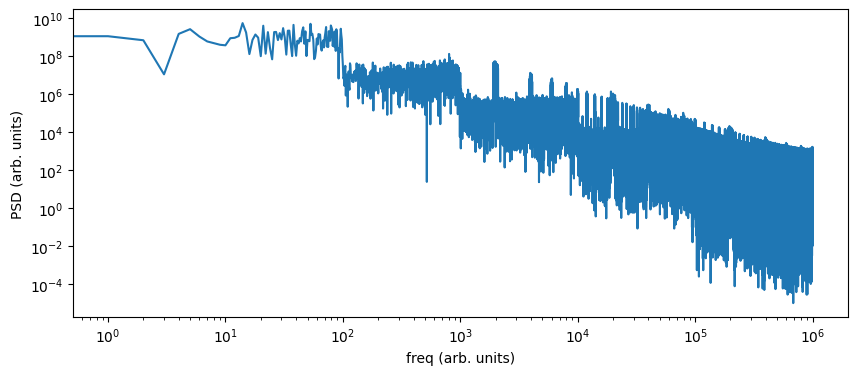

In [48]:
f=plt.gcf()
f.set_size_inches(10,4)
plt.loglog(np.abs(np.fft.rfft(spec))**2/N**2)
plt.xlabel("freq (arb. units)")
plt.ylabel("PSD (arb. units)")
# plt.loglog(np.abs(ps))
# plt.plot(ps)
# plt.ylim(1e-2,1e2)

Text(0, 0.5, 'PSD (arb. units)')

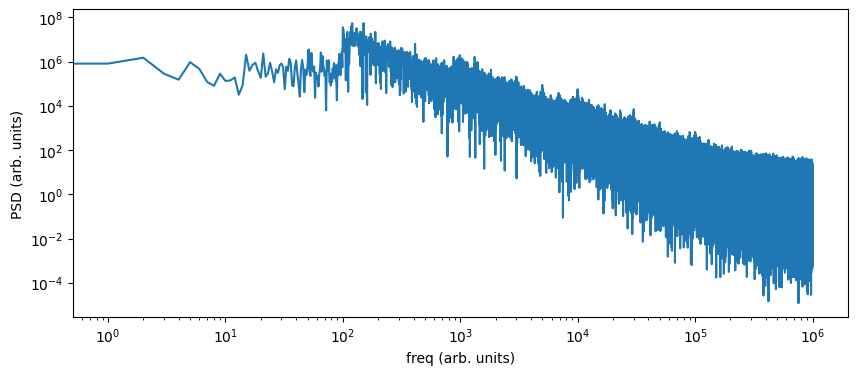

In [325]:
f=plt.gcf()
f.set_size_inches(10,4)
plt.loglog(np.abs(np.fft.rfft(spec))**2/N**2)
plt.xlabel("freq (arb. units)")
plt.ylabel("PSD (arb. units)")
# plt.loglog(np.abs(ps))
# plt.plot(ps)
# plt.ylim(1e-2,1e2)